In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import time
from RecursiveFeatureSelector import RecursiveFeatureSelector
from sklearn.model_selection import cross_val_score

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
train.shape, test.shape

((891, 12), (418, 11))

In [9]:
def checkna(DataFrame, mode='plot'):
    df = DataFrame.copy()
    for f in df.columns:
        df[f].replace(df[f].dropna().unique(), [i for i in range(df[f].dropna().nunique())], inplace=True)
        
    desc = df.describe().T
    desc['missing%'] = 1 - (desc['count'] / len(df))
    desc.sort_values('missing%', ascending=False, inplace=True)
    impute = list(desc[desc['missing%'] < 0.5].iloc[:, -1].index)
    no_impute = list(desc[(desc['missing%'] >= 0.5) & (desc['missing%'] <= 0.95)].iloc[:, -1].index)
    discard = list(desc[desc['missing%'] > 0.95].iloc[:, -1].index)
    desc = desc[desc['missing%'] > 0] 
    
    if mode == 'text':
        print(desc['missing%'] * 100)
    if mode == 'plot':
        # visualize 
        fig, ax = plt.subplots(figsize = (10, 15))
        sns.barplot(y=desc['missing%'].index, x=desc['missing%'], palette='mako')
        plt.xlabel('%Missing')
        plt.ylabel('Features')
        plt.title('Percent missing Values')
        sns.despine()
        plt.show()

    # return impute, no_impute, discard

In [10]:
checkna(train, mode='text')

Cabin       77.104377
Age         19.865320
Embarked     0.224467
Name: missing%, dtype: float64


In [11]:
checkna(test, mode='text')

Cabin    78.229665
Age      20.574163
Fare      0.239234
Name: missing%, dtype: float64


In [12]:
for df in [train, test]:
    df.drop(['Cabin', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [13]:
train.shape, test.shape

((891, 9), (418, 8))

In [14]:
class MissForest:
    def __init__(self):
        pass
    
    def impute(self, df, impute, var_type, diff_threshold=0.01, max_iter=5, verbose=0, estimator='Random Forest'):
        start = time.time()
        df3 = df.copy()
        
        pd.options.mode.chained_assignment = None  # default='warn'
                
        encode_col = [f for f in df.columns if isinstance(df[f].sample(1).values[0], str)]
        
        for c in encode_col:  
            df3[c].replace(df[c].dropna().unique(), range(df[c].dropna().nunique()), inplace=True) # label encoding
            if c == impute:
                impute_map = ({k:v for (k,v) in zip(df[c].dropna().unique(), range(df[c].dropna().nunique()))}) 
                impute_map = {v:k for (k,v) in impute_map.items()} 
        
        non_null = list(set([feat for feat, val in zip(df.isnull().sum().index, df.isnull().sum()) if val == 0] + [impute]))

        if verbose == 1:
            print(f'There are {len(non_null)} features have no missing values.\n')
        n_iter = 1
        track = {}
        
        # predict_set is already empyt
        while True:
            intra_start = time.time()
            df2=df3[non_null].copy()
            df2['Training/Predict'] = np.where(df2[impute].isnull(), 'predict', 'training')
            predict_set = df2[df2['Training/Predict'] == 'predict']
            training_set = df2[df2['Training/Predict'] == 'training']

            if n_iter == 1:
                predict_set[impute].fillna(df2[impute].median(), inplace=True) if var_type == 'con' else predict_set[impute].fillna(df2[impute].mode().values[0], inplace=True)
                    
            if n_iter > 1:
                for idx, pred in zip(predict_set.index, res):
                    predict_set.loc[idx, impute] = pred
            
            if estimator == 'Random Forest':
                model = RandomForestRegressor() if var_type == 'con' else RandomForestClassifier()
                
            if estimator != 'Random Forest':
                model = estimator
        
            model.fit(training_set[non_null].drop(impute, axis=1), training_set[impute])
            if predict_set[non_null].drop(impute, axis=1).shape[0] != 0:
                res = model.predict(predict_set[non_null].drop(impute, axis=1))
            else:
                raise Exception(f'Feature {impute} does not contain any missing values.')
            
            track[f'iter{n_iter}'] = res
            
            if n_iter > 1 and var_type == 'con':
                score_diff = round(((track[f'iter{n_iter}'] - track[f'iter{n_iter - 1}']) / track[f'iter{n_iter - 1}']).sum(), 3)
                if n_iter % 1 == 0 and verbose == 1:
                    print(f'iter {n_iter}:\n  {abs(score_diff * 100)}%')
                if abs(score_diff) <= diff_threshold:
                    if verbose == 1:
                        print('\nStopping Criteria Reached')
                    break
            
            if n_iter > 1 and var_type == 'cat':
                if verbose == 1:
                    print(f'iter {n_iter - 1}:\n  {res}')         
                if (track[f'iter{n_iter}'] == track[f'iter{n_iter - 1}']).all():
                    if verbose == 1:
                        print('\nStopping Criteria Reached (impute result are the same)')
                    break
                    
            if max_iter <= 1:
                print('\nStopping Criteria Reached (max iter reached)')
                break
                    
            n_iter += 1
            max_iter -= 1
            if verbose == 1:
                print(f'Time Spent: {round(time.time() - intra_start, 4)}(s)\n')
            
        pd.options.mode.chained_assignment = 'warn'  
        if verbose == 1:
            print(f'Total Time Spent: {round(time.time() - start, 2)}(s)')
        
        if var_type == 'con':
            return pd.concat([training_set[impute], predict_set[impute]], axis=0).sort_index()
        
        if var_type == 'cat':
            return pd.concat([training_set[impute], predict_set[impute]], axis=0).sort_index().replace(impute_map)

In [15]:
mf = MissForest()
train['Embarked'] = mf.impute(df=train, 
          impute='Embarked', 
          var_type='cat', 
          diff_threshold=0.01, 
          max_iter=999, 
          verbose=0, 
          estimator='Random Forest')

train['Age'] = mf.impute(df=train, 
          impute='Age', 
          var_type='con', 
          diff_threshold=0.01, 
          max_iter=999, 
          verbose=0, 
          estimator='Random Forest')

test['Fare'] = mf.impute(df=test, 
          impute='Fare', 
          var_type='con', 
          diff_threshold=0.01, 
          max_iter=999, 
          verbose=0, 
          estimator='Random Forest')

test['Age'] = mf.impute(df=test, 
          impute='Age', 
          var_type='con', 
          diff_threshold=0.01, 
          max_iter=999, 
          verbose=0, 
          estimator='Random Forest')

In [16]:
checkna(train, mode='text')

Series([], Name: missing%, dtype: float64)


In [17]:
checkna(train, mode='text')

Series([], Name: missing%, dtype: float64)


In [18]:
from WordCountinColumn import word_count_in_col
wcc = word_count_in_col()
wcc.fit(train['Name'])

In [19]:
pd.Series(wcc.res).sort_values(ascending=False).head(10)

Mr.        517
Miss.      182
Mrs.       125
William     63
John        44
Master.     40
Henry       33
James       24
George      23
Charles     23
dtype: int64

In [20]:
def give_title(row):
    for t in ['Mr.', 'Miss.', 'Mrs.', 'Master.']:
        if t in row:
            return t 
        else:
            return 'Rare'

In [21]:
train['Name'] = train['Name'].apply(give_title)
test['Name'] = test['Name'].apply(give_title)

In [22]:
train['Family_size'] = train['SibSp'] + train['Parch']
test['Family_size'] = test['SibSp'] + test['Parch']

In [23]:
train['IsAlone'] = train['Family_size'].apply(lambda x: 1 if x == 1 else 0)
test['IsAlone'] = test['Family_size'].apply(lambda x: 1 if x == 1 else 0)

In [24]:
for f in ['Name', 'Sex', 'Embarked']:
    for df in [train, test]:
        df[f].replace(df[f].unique(), range(df[f].nunique()), inplace=True)

In [96]:
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']
X_test = test

In [97]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

# Construct Model

# LogisticRegression

In [128]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
cross_val_score(lr, X_train, y_train, cv=5).mean()

0.8047140794677045

In [105]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = LogisticRegression(penalty='l2', C=0.0101, solver=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 

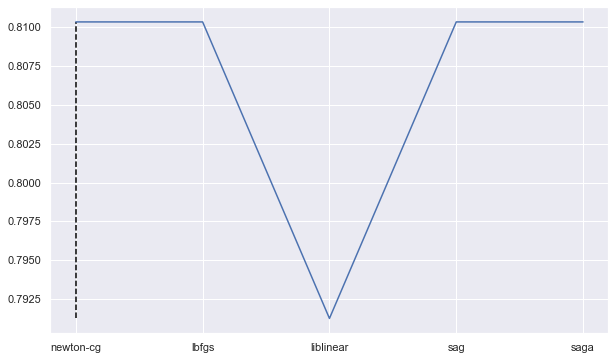

Best Param: newton-cg, Best Score: 0.8103508882053857


In [106]:
tune(['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], X_train, y_train, 5)

 
Searching the best subset of features with LogisticRegression...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass', 'Name', 'Sex', 'Embarked', 'IsAlone', 'Family_size']
 
Best Accuracy: 
     0.8126
 
Total Time Spent: 2.67(s)


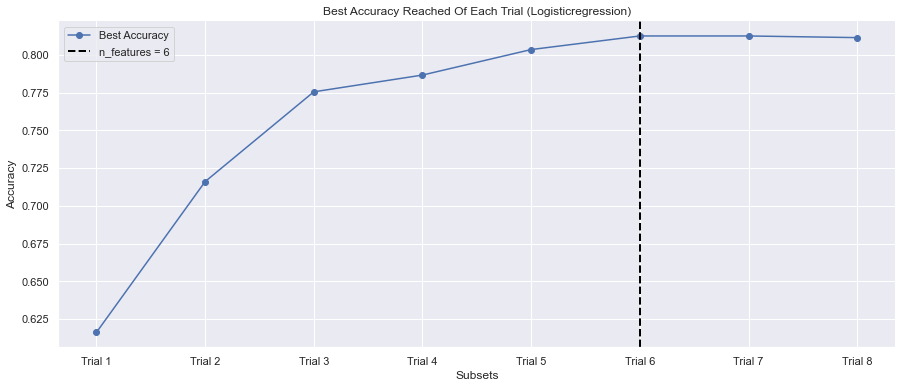

--------------------------------End of Recursive Features Selection (LogisticRegression)-------------------------------


In [107]:
lr = LogisticRegression(penalty='l2', C=0.0101)
rfs = RecursiveFeatureSelector()
rfs.search(estimators=lr, X=X_train, y=y_train, cv=5, scoring='accuracy', verbose=2)

In [125]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = LogisticRegression(penalty='l2', C=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 

# KNN

In [153]:
from sklearn.neighbors import KNeighborsClassifier

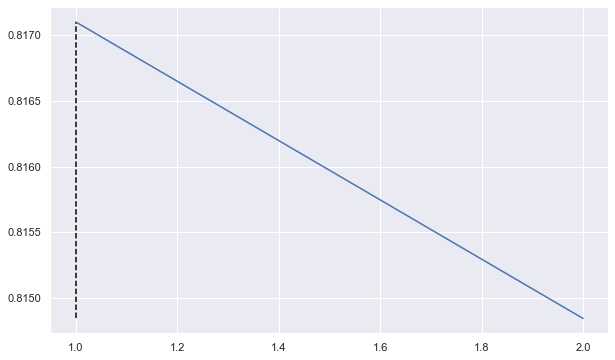

Best Param: 1, Best Score: 0.8170987383089574


In [160]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = KNeighborsClassifier(n_neighbors=5, algorithm='brute', p=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 

tune([1,2], X_train,y_train, 5)

 
Searching the best subset of features with KNeighborsClassifier...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Name', 'Sex', 'Embarked', 'Family_size', 'Pclass', 'Fare', 'Parch']
 
Best Accuracy: 
     0.8193
 
Total Time Spent: 3.28(s)


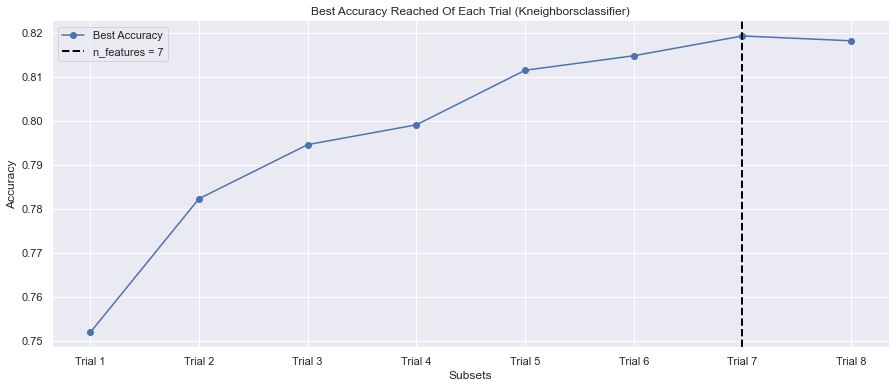

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------


In [161]:
knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
rfs = RecursiveFeatureSelector()
rfs.search(estimators=knn, X=X_train, y=y_train, cv=5, scoring='accuracy', verbose=2)

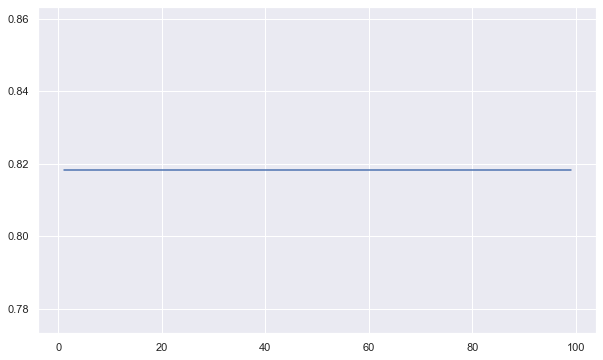

Best Param: 1, Best Score: 0.8181972255351202


In [165]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = KNeighborsClassifier(n_neighbors=10, leaf_size=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 

tune(np.arange(1, 100, 1), X_train2,y_train2, 5)

 
Searching the best subset of features with KNeighborsClassifier...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex', 'Family_size', 'Name', 'Age']
 
Best Accuracy: 
     0.8249
 
Total Time Spent: 0.71(s)


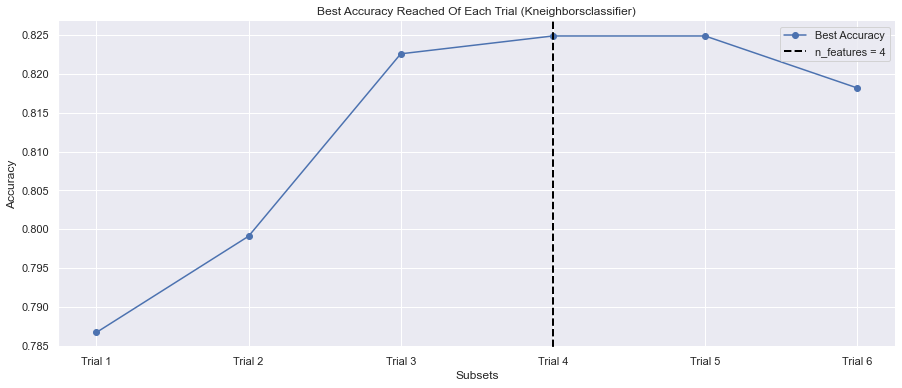

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------


In [166]:
knn = KNeighborsClassifier(n_neighbors=10)
rfs = RecursiveFeatureSelector()
rfs.search(estimators=knn, X=X_train, y=y_train, cv=5, scoring='accuracy', verbose=2)

# AdaBoostClassifier

In [167]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
cross_val_score(ada, X_train, y_train, cv=5).mean()

0.8092335697696316

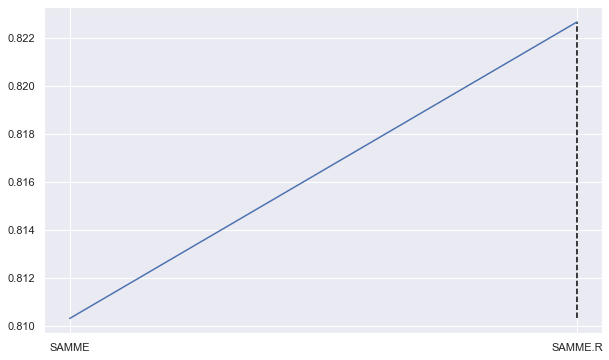

Best Param: SAMME.R, Best Score: 0.8226853304877283


In [171]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = AdaBoostClassifier(n_estimators=17, learning_rate=0.9801, algorithm=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 

tune(['SAMME', 'SAMME.R'], X_train2,y_train2, 5)

 
Searching the best subset of features with AdaBoostClassifier...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex', 'Family_size', 'Age', 'IsAlone', 'SibSp', 'Parch', 'Embarked', 'Name', 'Pclass']
 
Best Accuracy: 
     0.8227
 
Total Time Spent: 1.68(s)


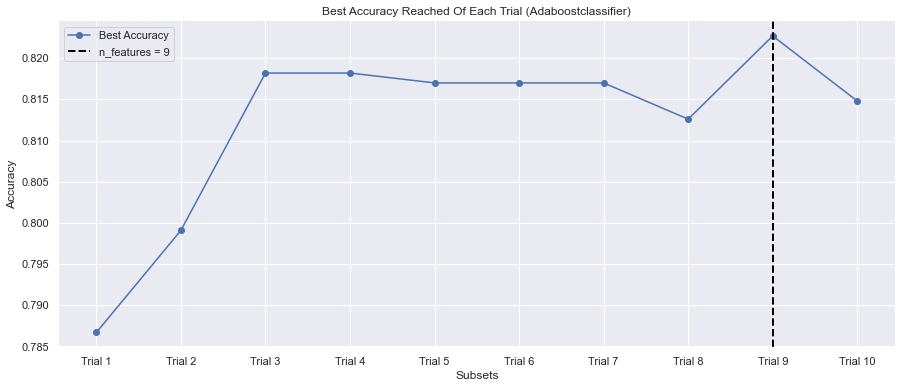

--------------------------------End of Recursive Features Selection (AdaBoostClassifier)-------------------------------


In [173]:
ada = AdaBoostClassifier(n_estimators=17, learning_rate=0.9801)
rfs = RecursiveFeatureSelector()
rfs.search(estimators=ada, X=X_train, y=y_train, cv=5, scoring='accuracy', verbose=2, tolerance=999)

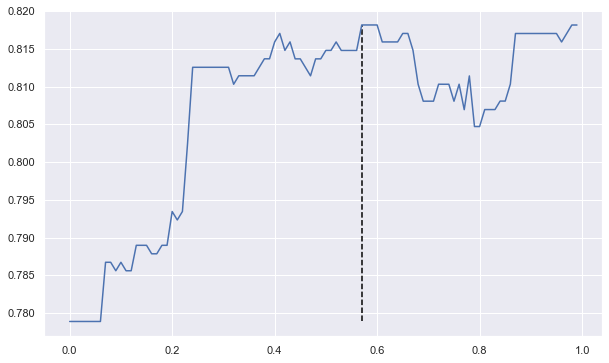

Best Param: 0.5701, Best Score: 0.8181658401858012


In [180]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = AdaBoostClassifier(n_estimators=11, learning_rate=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 

tune(np.arange(.0001, 1, .01), X_train2[rfs.best_subsets['AdaBoostClassifier']],y_train2, 5)

# CatBoost

In [181]:
from sklearn.ensemble import GradientBoostingClassifier
grad = GradientBoostingClassifier()
cross_val_score(grad, X_train, y_train, cv=5).mean()

0.830500282468144

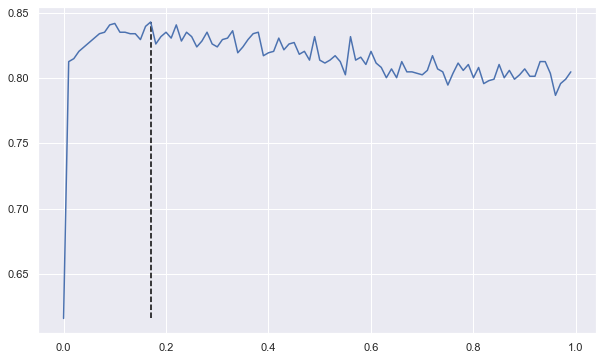

Best Param: 0.1701, Best Score: 0.8428661100998054


In [184]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = GradientBoostingClassifier(n_estimators=81, learning_rate=0.1701)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 

tune(np.arange(.0001, 1, .01), X_train, y_train, 5)

 
Searching the best subset of features with GradientBoostingClassifier...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex', 'SibSp', 'Name', 'Parch', 'Pclass', 'Age', 'Fare', 'Embarked', 'IsAlone']
 
Best Accuracy: 
     0.8429
 
Total Time Spent: 2.63(s)


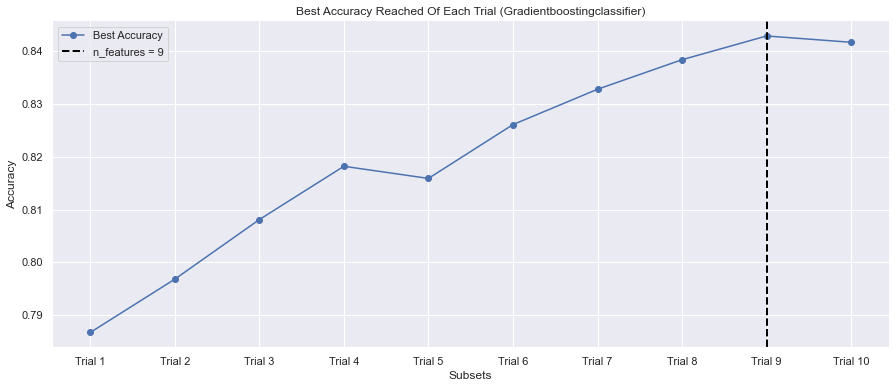

--------------------------------End of Recursive Features Selection (GradientBoostingClassifier)-------------------------------


In [186]:
grad = GradientBoostingClassifier(n_estimators=81, learning_rate=0.1701)
rfs = RecursiveFeatureSelector()
rfs.search(estimators=grad, X=X_train, y=y_train, cv=5, scoring='accuracy', verbose=2, tolerance=999)

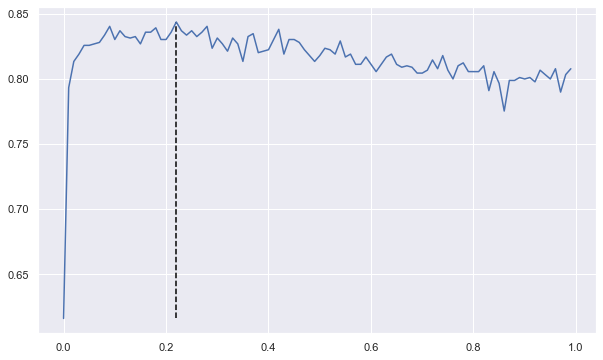

Best Param: 0.2201, Best Score: 0.8440085368150146


In [190]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = GradientBoostingClassifier(n_estimators=69, learning_rate=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 

tune(np.arange(.0001, 1, .01), X_train[rfs.best_subsets['GradientBoostingClassifier']], y_train, 5)

In [192]:
from sklearn.svm import SVC
svc = SVC()
cross_val_score(svc, X_train, y_train, cv=5).mean()

0.8215491808423827

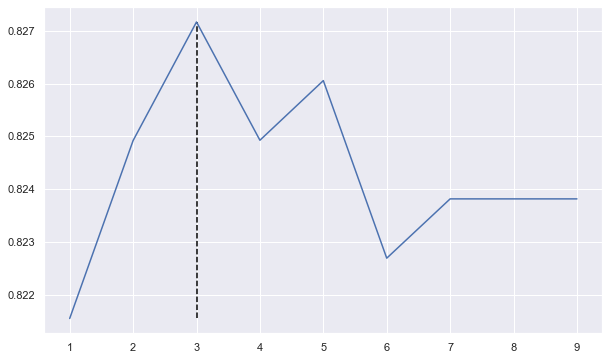

Best Param: 3, Best Score: 0.8271671583704727


In [203]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = SVC(C=3, )
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 

tune(np.arange(1,10,1), X_train, y_train, 5)

 
Searching the best subset of features with SVC...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex', 'SibSp', 'Age', 'Parch', 'Pclass', 'Name', 'Family_size']
 
Best Accuracy: 
     0.835
 
Total Time Spent: 2.18(s)


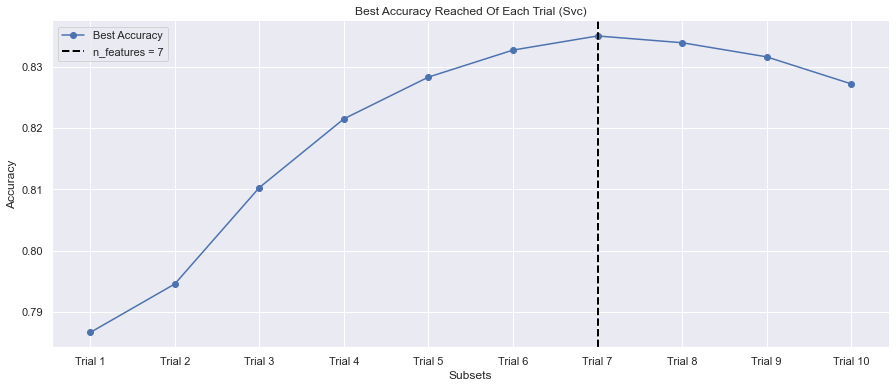

--------------------------------End of Recursive Features Selection (SVC)-------------------------------


In [204]:
svc = SVC(C=3)
rfs = RecursiveFeatureSelector()
rfs.search(estimators=svc, X=X_train, y=y_train, cv=5, scoring='accuracy', verbose=2, tolerance=999)

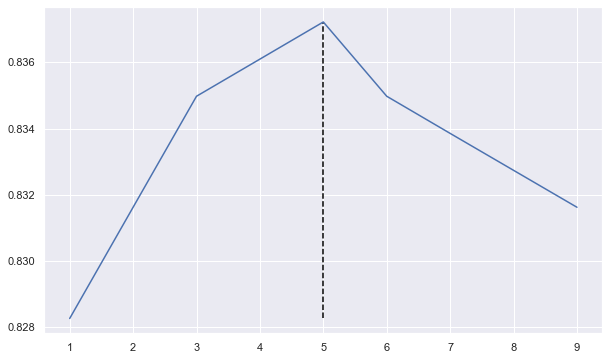

Best Param: 5, Best Score: 0.8372230242922603


In [206]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = SVC(C=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 

tune(np.arange(1,10,1), X_train[rfs.best_subsets['SVC']], y_train, 5)

# RandomForestClassifier

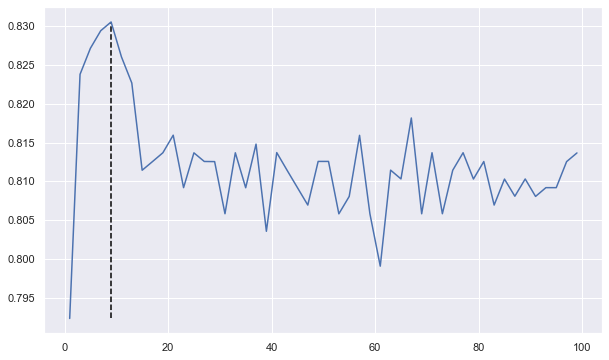

Best Param: 9, Best Score: 0.830525390747599


In [64]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = RandomForestClassifier(n_estimators=81, max_depth=9)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 

tune(np.arange(1, 100, 2), X_train,y_train, 5)

# XGBC

In [34]:
from xgboost import XGBClassifier
xgbc = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
cross_val_score(xgbc, X_train, y_train, cv=5).mean()

0.8215303496327915

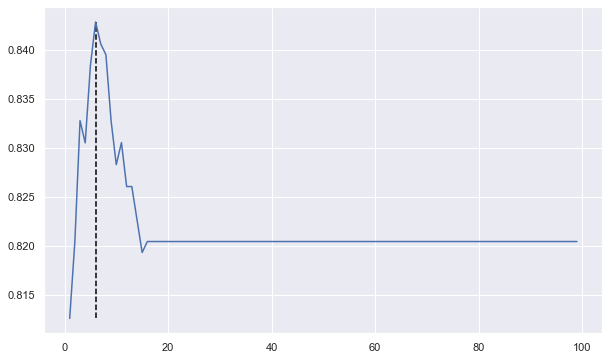

Best Param: 6, Best Score: 0.8428661100998054


In [71]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = XGBClassifier(n_estimators=13, max_depth=n, use_label_encoder=False, eval_metric='logloss')
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 

tune(np.arange(1, 100, 1), X_train, y_train, cv=5)

xgbc(n_estimator=13): acc=0.8428661100998054

 
Searching the best subset of features with XGBClassifier...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex', 'Fare', 'Name', 'Family_size', 'Pclass']
 
Best Accuracy: 
     0.835
 
Total Time Spent: 33.19(s)


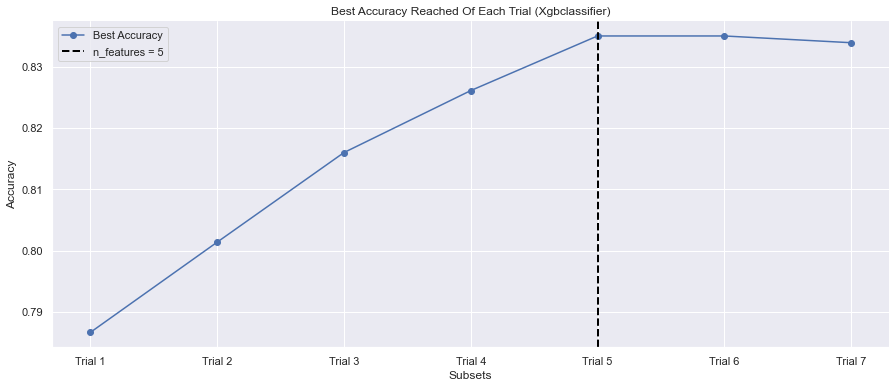

--------------------------------End of Recursive Features Selection (XGBClassifier)-------------------------------


In [72]:
xgbc = XGBClassifier(n_estimator=13, use_label_encoder=False, eval_metric='logloss')
rfs = RecursiveFeatureSelector()
rfs.search(estimators=xgbc, X=X_train, y=y_train, cv=5, scoring='accuracy', verbose=2)

 
Searching the best subset of features with RandomForestClassifier...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex', 'SibSp', 'Name', 'Family_size', 'Fare', 'Pclass', 'IsAlone']
 
Best Accuracy: 
     0.8373
 
Total Time Spent: 7.47(s)


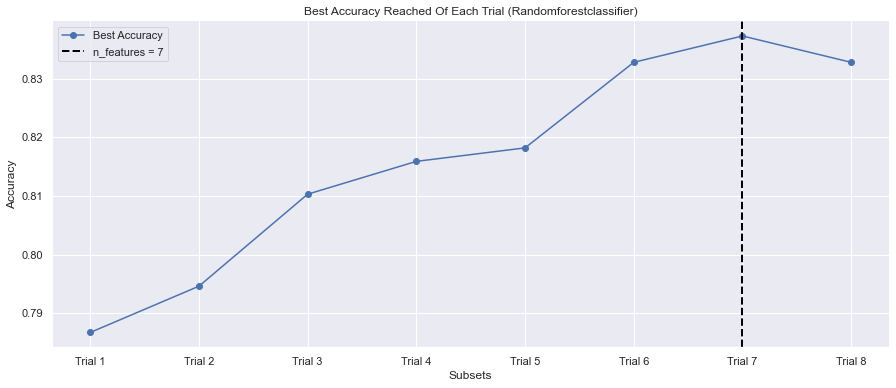

--------------------------------End of Recursive Features Selection (RandomForestClassifier)-------------------------------


In [65]:
rfc = RandomForestClassifier(n_estimators=81, max_depth=9)
rfs = RecursiveFeatureSelector()
rfs.search(estimators=rfc, X=X_train, y=y_train, cv=5, scoring='accuracy', verbose=2)

# RadiusNeighborsClassifier

In [335]:
from sklearn.neighbors import RadiusNeighborsClassifier
radius = RadiusNeighborsClassifier()
cross_val_score(radius, X_train, y_train, cv=5).mean()

0.7766493001067103

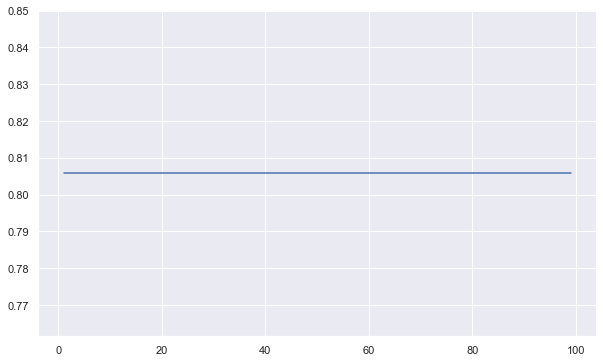

Best Param: 1, Best Score: 0.8058125666938671


In [349]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = RadiusNeighborsClassifier(radius=1.0349999999999961, algorithm='kd_tree', leaf_size=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 

tune(np.arange(1, 100, 1), X_train, y_train, cv=5)

 
Searching the best subset of features with RadiusNeighborsClassifier...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass', 'Name', 'Embarked', 'IsAlone', 'Age', 'Fare']
 
Best Accuracy: 
     0.8059
 
Total Time Spent: 3.55(s)


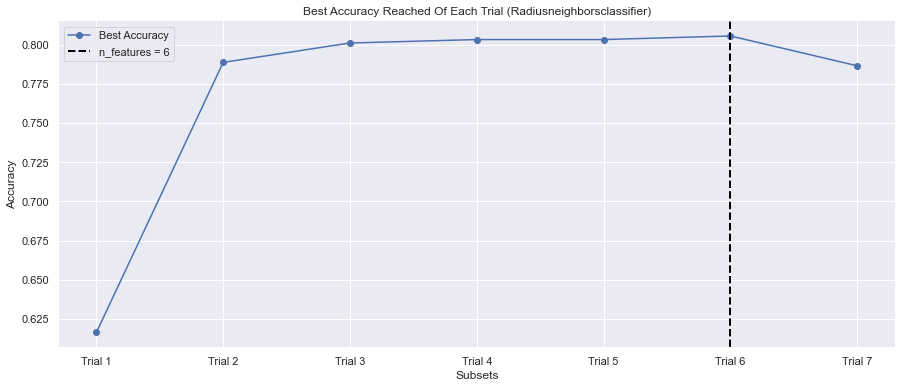

--------------------------------End of Recursive Features Selection (RadiusNeighborsClassifier)-------------------------------


In [350]:
radius = RadiusNeighborsClassifier(radius=1.0349999999999961)
rfs = RecursiveFeatureSelector()
rfs.search(estimators=radius, X=X_train, y=y_train, cv=5, scoring='accuracy', verbose=2)

# ExtraTree

In [365]:
from sklearn.tree import ExtraTreeClassifier
extra = ExtraTreeClassifier()
cross_val_score(extra, X_train, y_train, cv=5).mean()
# not worthy

0.763210093528341

In [37]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(verbose=0)
cross_val_score(cat, X_train, y_train, cv=5).mean()

0.8294206264515724

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 4673, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 1978, in _fit
    train_params = self._prepare_train_params(
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 1910, in _prepare_train_params
    _check_train_params(params)
  File "_catboos

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 4673, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 1978, in _fit
    train_params = self._prepare_train_params(
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 1910, in _prepare_train_params
    _check_train_params(params)
  File "_catboos

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 4673, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 1978, in _fit
    train_params = self._prepare_train_params(
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 1910, in _prepare_train_params
    _check_train_params(params)
  File "_catboos

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 4673, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 1978, in _fit
    train_params = self._prepare_train_params(
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 1910, in _prepare_train_params
    _check_train_params(params)
  File "_catboos

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 4673, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 1978, in _fit
    train_params = self._prepare_train_params(
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 1910, in _prepare_train_params
    _check_train_params(params)
  File "_catboos

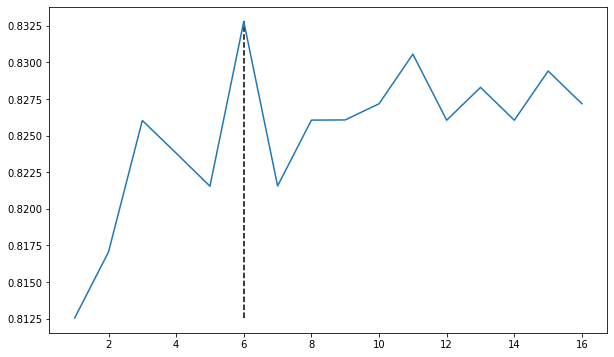

Best Param: 6, Best Score: 0.8327914129684265


In [43]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = CatBoostClassifier(n_estimators=55, max_depth=n, verbose=0)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 

tune(np.arange(1, 100, 1), X_train, y_train, cv=5)

 
Searching the best subset of features with <catboost.core.CatBoostClassifier object at 0x7fa029542d60>...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex', 'Family_size', 'Age', 'Pclass', 'Name', 'Fare', 'SibSp']
 
Best Accuracy: 
     0.8339
 
Total Time Spent: 2.25(s)


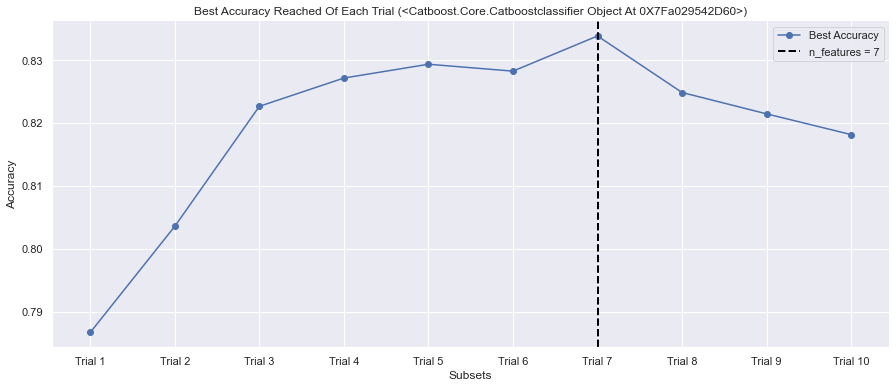

--------------------------------End of Recursive Features Selection (<catboost.core.CatBoostClassifier object at 0x7fa029542d60>)-------------------------------


In [45]:
cat = CatBoostClassifier(n_estimators=55, verbose=0)
rfs = RecursiveFeatureSelector()
rfs.search(estimators=cat, X=X_train, y=y_train, cv=5, scoring='accuracy', verbose=2, tolerance=999)

# One Hot Encoding

In [98]:
X_train2 = train.drop('Survived', axis=1).copy()
y_train2 = train['Survived'].copy()
X_test2 = test.copy()

def oh(df):
    res = [df]
    for f in cat:
        res.append(pd.get_dummies(df[f], prefix=f))

    return pd.concat(res, axis=1)

cat = ['Pclass', 'Name', 'Embarked']
X_train2 = oh(X_train2)
X_test2 = oh(X_test2)
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train2 = pd.DataFrame(scaler.fit_transform(X_train2), columns=X_train2.columns)
X_test2 = pd.DataFrame(scaler.fit_transform(X_test2), columns=X_test2.columns)

# LogisticRegression

In [207]:
lr = LogisticRegression()
cross_val_score(lr, X_train2, y_train2, cv=5).mean()

0.8148013307388112

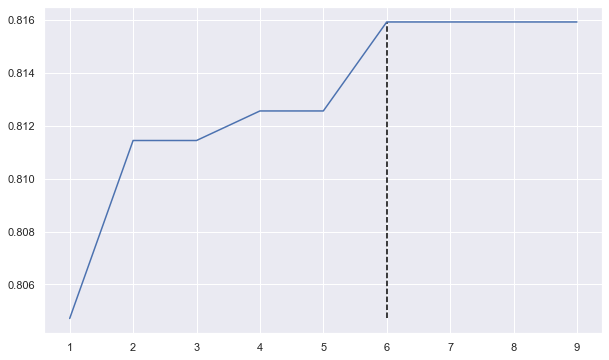

Best Param: 6, Best Score: 0.8159249262444291


In [214]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = LogisticRegression(C=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 

tune(np.arange(1,10,1), X_train, y_train, 5)

 
Searching the best subset of features with LogisticRegression...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex', 'Family_size', 'Pclass', 'Name', 'Pclass_1', 'Embarked', 'Age', 'Embarked_0', 'IsAlone', 'SibSp']
 
Best Accuracy: 
     0.8182
 
Total Time Spent: 4.65(s)


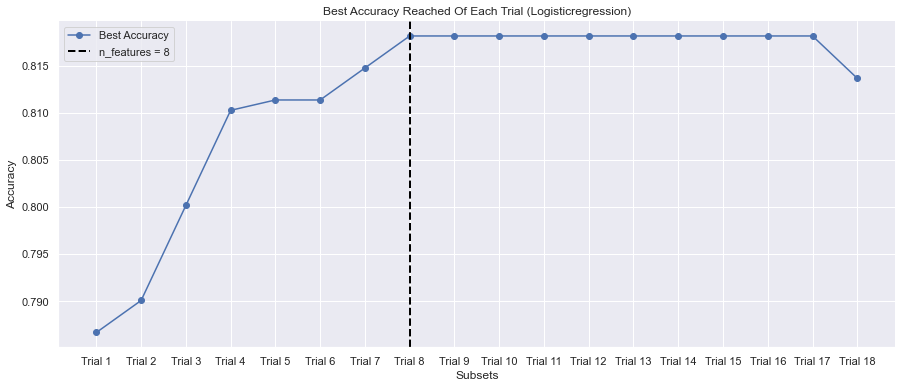

--------------------------------End of Recursive Features Selection (LogisticRegression)-------------------------------


In [215]:
lr = LogisticRegression(C=6)
rfs = RecursiveFeatureSelector()
rfs.search(estimators=lr, X=X_train2, y=y_train2, cv=5, scoring='accuracy', verbose=2)

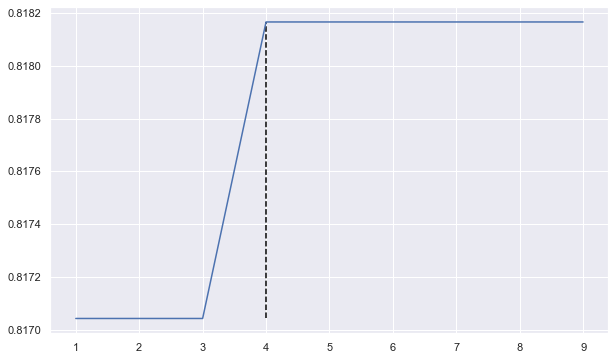

Best Param: 4, Best Score: 0.8181658401858012


In [216]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = LogisticRegression(C=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 
    
tune(np.arange(1,10,1), X_train2[rfs.best_subsets['LogisticRegression']], y_train2, cv=5)

# KNN

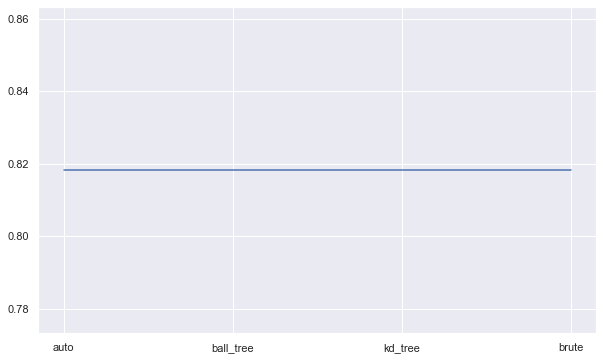

Best Param: auto, Best Score: 0.8181972255351202


In [220]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = KNeighborsClassifier(n_neighbors=10, algorithm=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 
    
tune(['auto', 'ball_tree', 'kd_tree', 'brute'], X_train2, y_train2, cv=5)

 
Searching the best subset of features with KNeighborsClassifier...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex', 'SibSp', 'Name', 'Parch']
 
Best Accuracy: 
     0.8238
 
Total Time Spent: 4.02(s)


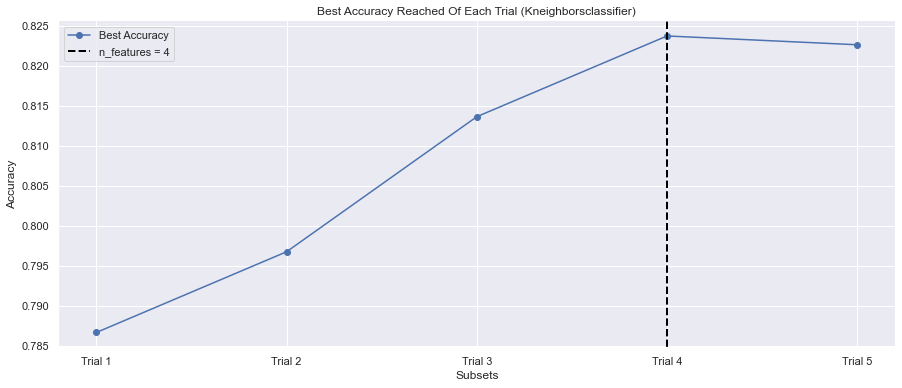

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------


In [221]:
knn = KNeighborsClassifier(n_neighbors=10)
rfs = RecursiveFeatureSelector()
rfs.search(estimators=knn, X=X_train2, y=y_train2, cv=5, scoring='accuracy', verbose=2)

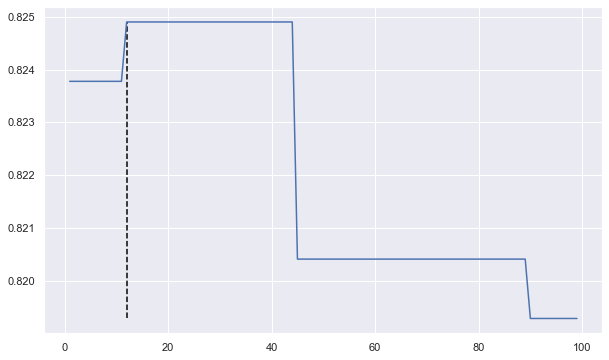

Best Param: 12, Best Score: 0.8249011361496453


In [228]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = KNeighborsClassifier(n_neighbors=11, leaf_size=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 
    
tune(np.arange(1, 100,1), X_train2[rfs.best_subsets['KNeighborsClassifier']], y_train2, cv=5)

# AdaBoostClassifier

In [229]:
ada = AdaBoostClassifier()
cross_val_score(ada, X_train2, y_train, cv=5).mean()

0.8092335697696316

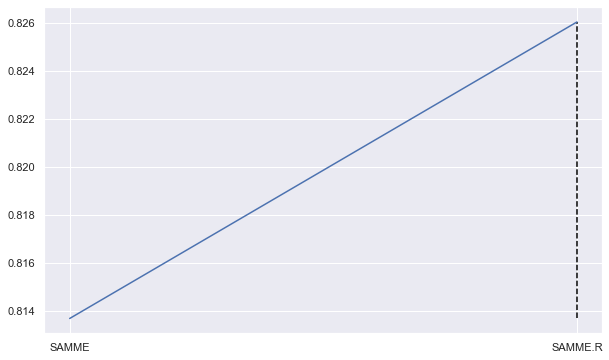

Best Param: SAMME.R, Best Score: 0.8260561170045824


In [234]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = AdaBoostClassifier(n_estimators=20, learning_rate=1.0201, algorithm=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 
    
tune(['SAMME', 'SAMME.R'], X_train2, y_train2, cv=5)

 
Searching the best subset of features with AdaBoostClassifier...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex', 'Family_size', 'Age', 'SibSp', 'Parch', 'Embarked', 'IsAlone', 'Pclass_2', 'Embarked_0', 'Embarked_2', 'Embarked_1', 'Name', 'Pclass', 'Fare', 'Name_0', 'Pclass_1', 'Pclass_3', 'Name_1']
 
Best Accuracy: 
     0.8261
 
Total Time Spent: 5.6(s)


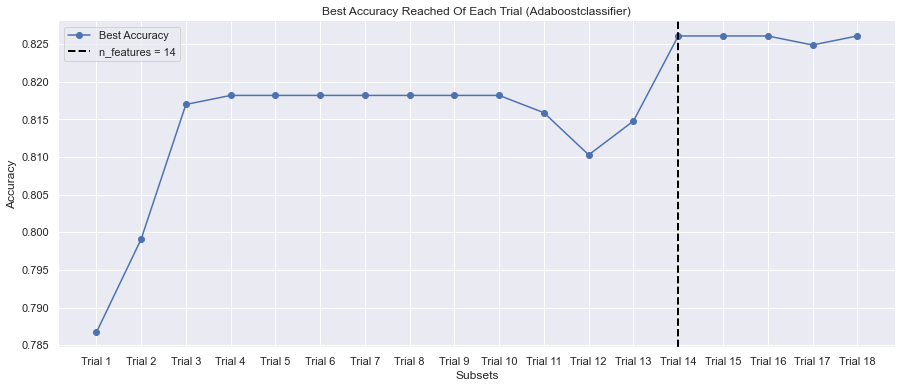

--------------------------------End of Recursive Features Selection (AdaBoostClassifier)-------------------------------


In [236]:
ada = AdaBoostClassifier(n_estimators=20, learning_rate=1.0201)
rfs = RecursiveFeatureSelector()
rfs.search(estimators=ada, X=X_train2, y=y_train2, cv=5, scoring='accuracy', verbose=2, tolerance=999)

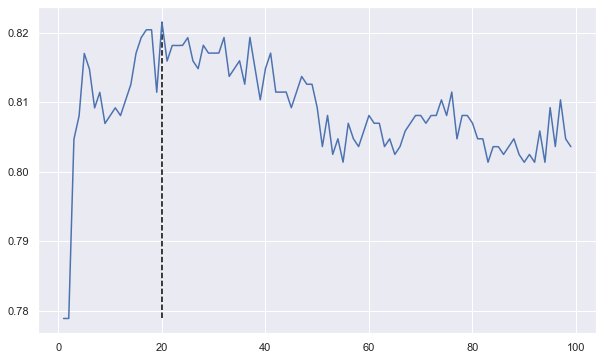

Best Param: 20, Best Score: 0.8215617349821104


In [237]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = AdaBoostClassifier(n_estimators=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 
    
tune(np.arange(1,100,1), X_train2[rfs.best_subsets['AdaBoostClassifier']], y_train2, cv=5)

# GradientBoost

In [238]:
grad = GradientBoostingClassifier()
cross_val_score(grad, X_train, y_train, cv=5).mean()

0.830500282468144

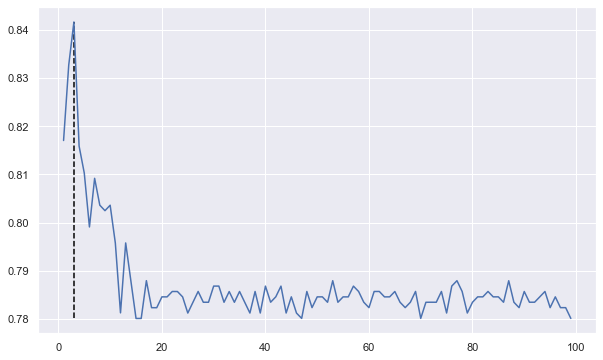

Best Param: 3, Best Score: 0.8417487916640513


In [242]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = GradientBoostingClassifier(n_estimators=79, learning_rate=0.2601, max_depth=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 
    
tune(np.arange(1, 100, 1), X_train2, y_train2, cv=5)

 
Searching the best subset of features with GradientBoostingClassifier...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex', 'Fare', 'Name', 'Pclass', 'Age', 'Pclass_3', 'Name_0', 'Name_1', 'Pclass_1', 'Embarked_2', 'Family_size', 'Pclass_2', 'SibSp', 'IsAlone', 'Parch']
 
Best Accuracy: 
     0.8451
 
Total Time Spent: 12.07(s)


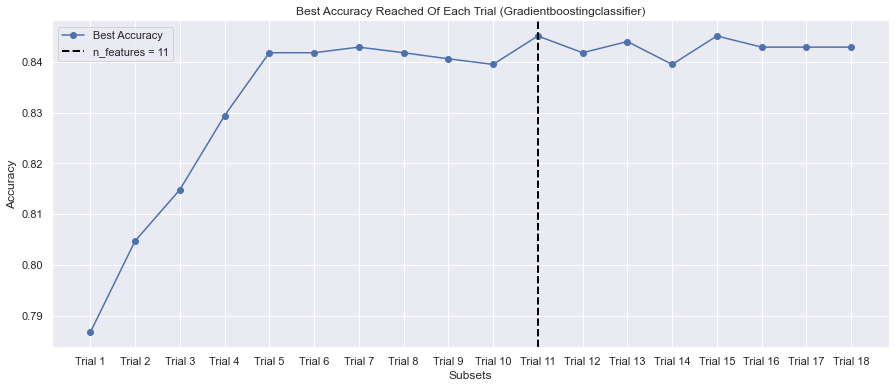

--------------------------------End of Recursive Features Selection (GradientBoostingClassifier)-------------------------------


In [243]:
grad = GradientBoostingClassifier(n_estimators=79, learning_rate=0.2601, max_depth=3)
rfs = RecursiveFeatureSelector()
rfs.search(estimators=grad, X=X_train2, y=y_train2, cv=5, scoring='accuracy', verbose=2, tolerance=999)

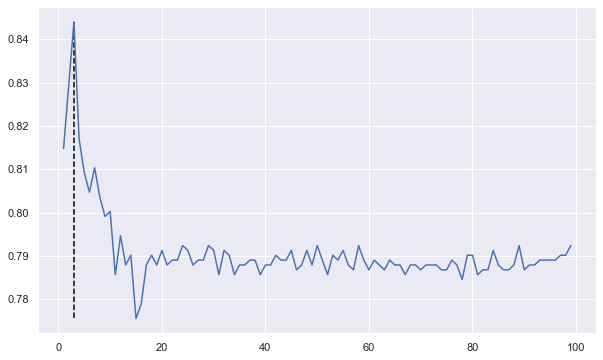

Best Param: 3, Best Score: 0.8439897056054233


In [247]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = GradientBoostingClassifier(n_estimators=71, learning_rate=0.2501, max_depth=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 
    
tune(np.arange(1, 100, 1), X_train2[rfs.best_subsets['GradientBoostingClassifier']], y_train2, cv=5)

# SVC

In [248]:
svc = SVC()
cross_val_score(svc, X_train2, y_train2, cv=5).mean()

0.821542903772519

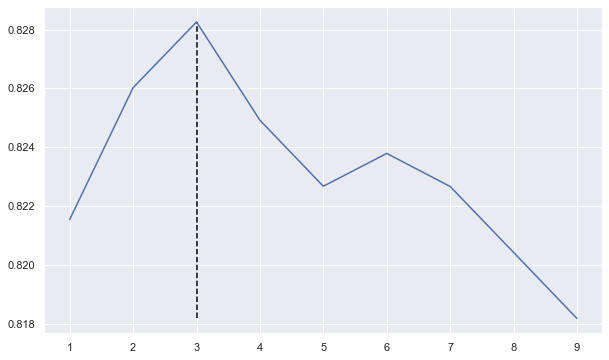

Best Param: 3, Best Score: 0.8282593685267716


In [250]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = SVC(C=3, )
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 
    
tune(np.arange(1, 10, 1), X_train2, y_train2, cv=5)

 
Searching the best subset of features with SVC...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex', 'Family_size', 'Name', 'Pclass', 'Fare', 'IsAlone', 'Pclass_1', 'Pclass_3', 'Name_0']
 
Best Accuracy: 
     0.835
 
Total Time Spent: 9.14(s)


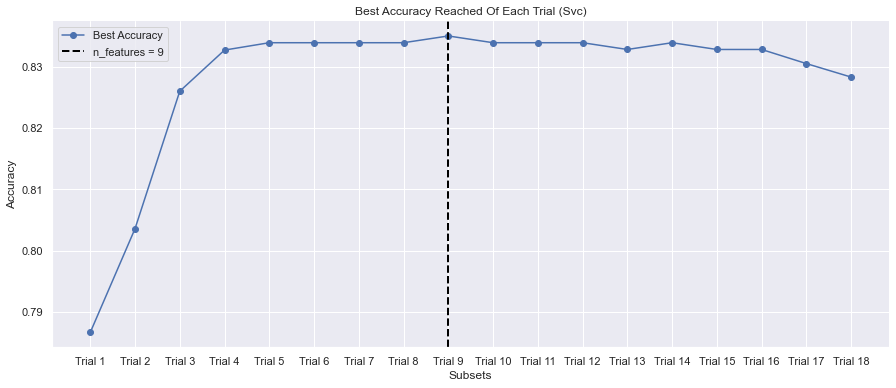

--------------------------------End of Recursive Features Selection (SVC)-------------------------------


In [251]:
svc = SVC(C=3)
rfs = RecursiveFeatureSelector()
rfs.search(estimators=svc, X=X_train2, y=y_train2, cv=5, scoring='accuracy', verbose=2, tolerance=999)

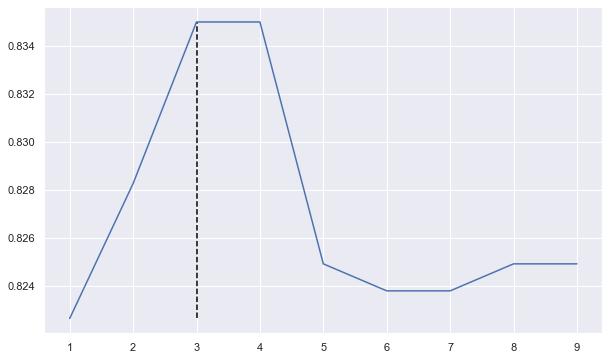

Best Param: 3, Best Score: 0.8349946644906158


In [252]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = SVC(C=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 
    
tune(np.arange(1, 10, 1), X_train2[rfs.best_subsets['SVC']], y_train2, cv=5)

# RandomForestClassifier

In [255]:
rfc = RandomForestClassifier()
cross_val_score(rfc, X_train2, y_train2, cv=5).mean()

0.8035842068922229

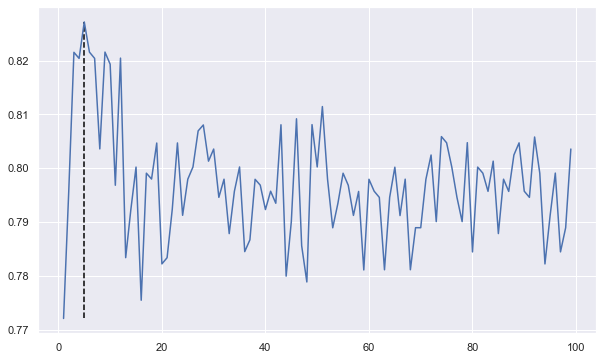

Best Param: 5, Best Score: 0.8271608813006089


In [258]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = RandomForestClassifier(n_estimators=5, max_depth=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 
    
tune(np.arange(1, 100, 1), X_train2, y_train2, cv=5)

 
Searching the best subset of features with RandomForestClassifier...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex', 'SibSp', 'Name', 'Pclass_2', 'Parch', 'Fare', 'Age', 'Pclass_1', 'Pclass_3', 'Name_1']
 
Best Accuracy: 
     0.844
 
Total Time Spent: 15.04(s)


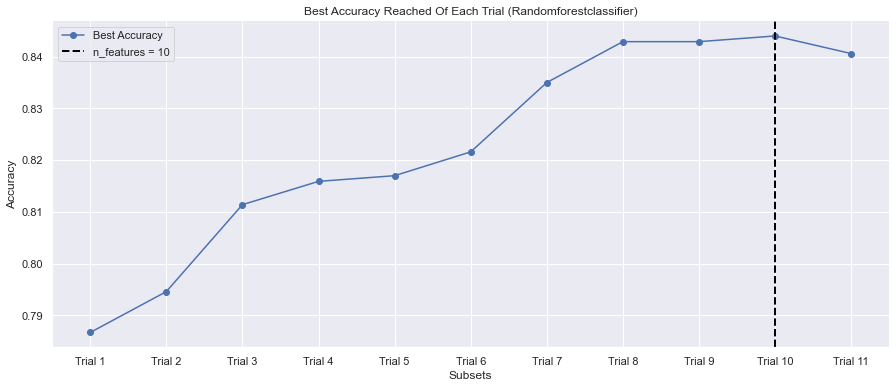

--------------------------------End of Recursive Features Selection (RandomForestClassifier)-------------------------------


In [82]:
rfc = RandomForestClassifier(n_estimators=75, max_depth=9)
rfs = RecursiveFeatureSelector()
rfs.search(estimators=rfc, X=X_train2, y=y_train2, cv=5, scoring='accuracy', verbose=2)

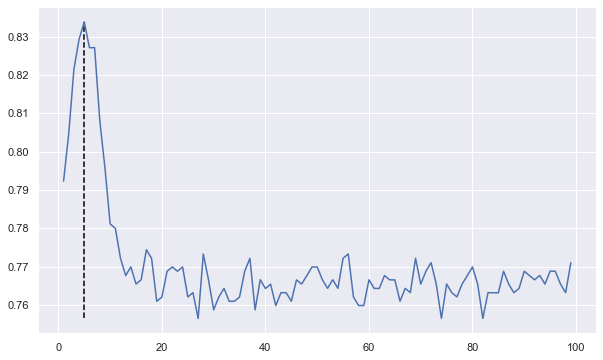

Best Param: 5, Best Score: 0.8338585148452703


In [261]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = RandomForestClassifier(n_estimators=75, max_depth=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 
    
tune(np.arange(1, 100, 1), X_train2[rfs.best_subsets['RandomForestClassifier']], y_train2, cv=5)

# XGBC

In [86]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = XGBClassifier(n_estimators=17, 
                              max_depth=n, 
                              use_label_encoder=False, 
                              eval_metric='logloss')
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 

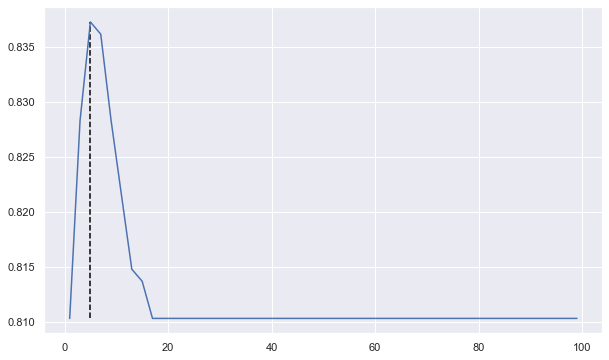

Best Param: 5, Best Score: 0.8372544096415793


In [87]:
tune(np.arange(1, 100, 2), X_train2, y_train2, cv=5)

xgbc(e_estimator=17): acc= 0.8428723871696693

In [ ]:
xgbc = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
cross_val_score(xgbc, X_)

 
Searching the best subset of features with XGBClassifier...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex', 'SibSp', 'Name', 'Pclass_3', 'Fare', 'Pclass', 'Family_size', 'IsAlone', 'Pclass_2']
 
Best Accuracy: 
     0.8462
 
Total Time Spent: 23.9(s)


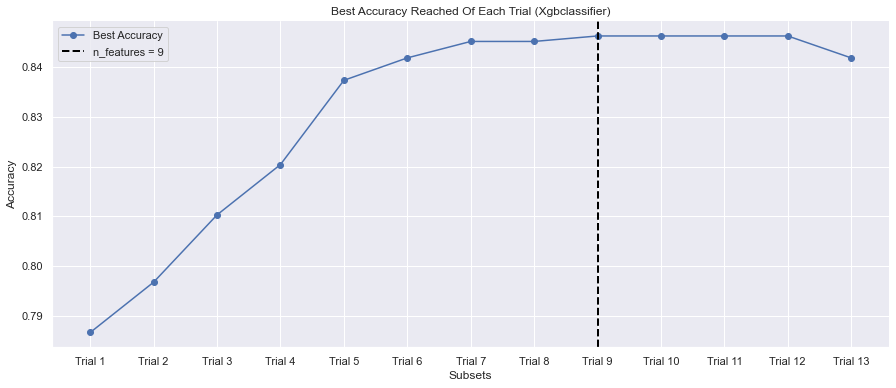

--------------------------------End of Recursive Features Selection (XGBClassifier)-------------------------------


In [88]:
xgbc = XGBClassifier(n_estimators=17, use_label_encoder=False, eval_metric='logloss')
rfs = RecursiveFeatureSelector()
rfs.search(estimators=xgbc, X=X_train2, y=y_train2, cv=5, scoring='accuracy', verbose=2)

# MLP

In [332]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=10000)
cross_val_score(mlp, X_train2, y_train2, cv=5).mean()

0.8260435628648548

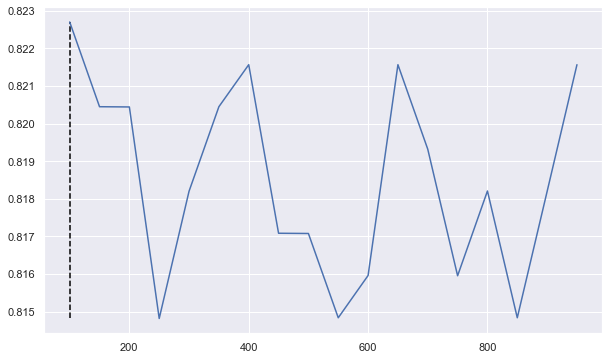

Best Param: 100, Best Score: 0.8227041616973197


In [334]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = MLPClassifier(hidden_layer_sizes=n, max_iter=10000)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 
    
tune(np.arange(100, 1000, 50), X_train2, y_train2, cv=5)

# RadiusNeighborsClassifier

In [351]:
from sklearn.neighbors import RadiusNeighborsClassifier
radius = RadiusNeighborsClassifier()
cross_val_score(radius, X_train2, y_train2, cv=5).mean()

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/n

nan

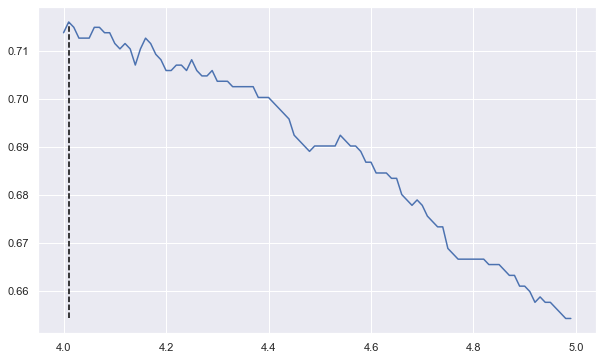

Best Param: 4.01, Best Score: 0.7161132383403428


In [361]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = RadiusNeighborsClassifier(radius=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 
    
tune(np.arange(4, 5, .01), X_train2, y_train2, cv=5)

 
Searching the best subset of features with RadiusNeighborsClassifier...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Fare', 'Name', 'Sex', 'Pclass', 'Family_size', 'Name_0', 'SibSp', 'Age', 'Pclass_3', 'Parch', 'Pclass_2', 'Name_1', 'Pclass_1', 'IsAlone', 'Embarked_2', 'Embarked_0', 'Embarked_1']
 
Best Accuracy: 
     0.7184
 
Total Time Spent: 2.44(s)


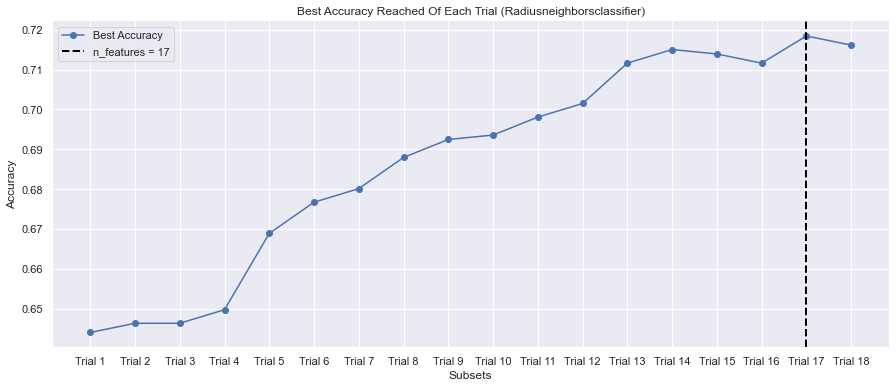

--------------------------------End of Recursive Features Selection (RadiusNeighborsClassifier)-------------------------------


In [363]:
radius = RadiusNeighborsClassifier(radius=4.01)
rfs = RecursiveFeatureSelector()
rfs.search(estimators=radius, X=X_train2, y=y_train2, cv=5, scoring='accuracy', verbose=2, tolerance=999)

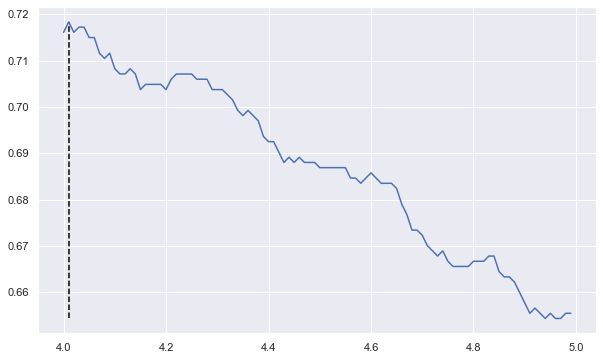

Best Param: 4.01, Best Score: 0.718354152281715


In [364]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = RadiusNeighborsClassifier(radius=n)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 
    
tune(np.arange(4, 5, .01), X_train2[rfs.best_subsets['RadiusNeighborsClassifier']], y_train2, cv=5)

In [49]:
cat = CatBoostClassifier(verbose=0)
cross_val_score(cat, X_train2, y_train2, cv=5).mean()

0.838390559286925

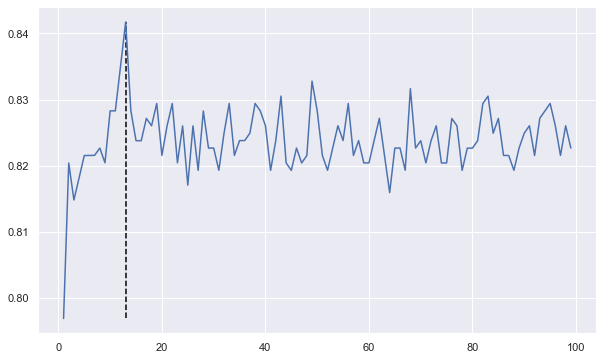

Best Param: 13, Best Score: 0.8417362375243238


In [51]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = CatBoostClassifier(n_estimators=n, verbose=0)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 
    
tune(np.arange(1, 100, 1), X_train2, y_train2, cv=5)

 
Searching the best subset of features with <catboost.core.CatBoostClassifier object at 0x7fa028d34be0>...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex', 'Family_size', 'Name', 'Pclass', 'Age', 'Fare', 'Embarked_0', 'Parch']
 
Best Accuracy: 
     0.8429
 
Total Time Spent: 7.12(s)


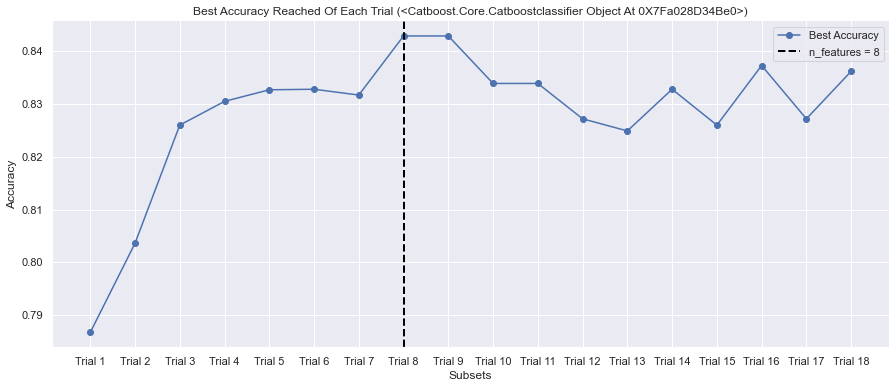

--------------------------------End of Recursive Features Selection (<catboost.core.CatBoostClassifier object at 0x7fa028d34be0>)-------------------------------


In [53]:
cat = CatBoostClassifier(n_estimators=13, verbose=0)
rfs = RecursiveFeatureSelector()
rfs.search(estimators=cat, X=X_train2, y=y_train2, cv=5, scoring='accuracy', verbose=2, tolerance=999)

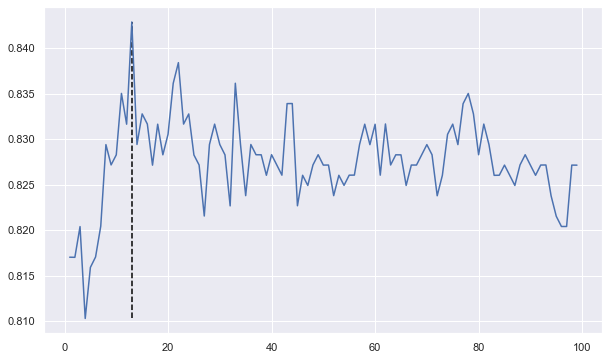

Best Param: 13, Best Score: 0.8428535559600778


In [54]:
def tune(space, X, y, cv):
    score = {}
    for n in space:
        model = CatBoostClassifier(n_estimators=n, verbose=0)
        score[n] = (cross_val_score(model, X, y, cv=5).mean())

    best_param = max(score, key=score.get)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(score.keys(), score.values())
    plt.vlines(best_param, 
               ymin=min(score.values()),
               ymax=max(score.values()),
               linestyles='--', 
               color='black')
    plt.show()
    
    print(f'Best Param: {best_param}, Best Score: {max(score.values())}') 
    
tune(np.arange(1, 100, 1), X_train2[rfs.best_subsets['<catboost.core.CatBoostClassifier object at 0x7fa028d34be0>']], y_train2, cv=5)

In [55]:
acc = pd.DataFrame({'lr':0.8181658401858012, 
 'knn':0.8249011361496453, 
 'ada':0.8260561170045824, 
 'gradient':0.8451, 
 'svc':0.835,
 'rfc':0.844, 
 'xgbc':0.8462, 
 'cat': 0.8429}, index=['acc']).T

In [56]:
acc.sort_values('acc', ascending=False)

,acc
xgbc,0.846200
gradient,0.845100
rfc,0.844000
cat,0.842900
svc,0.835000
ada,0.826056
knn,0.824901
lr,0.818166


In [62]:
xgbc = XGBClassifier(n_estimators=17, use_label_encoder=False, eval_metric='logloss')
xgbc.fit(X_train2[['Sex', 'SibSp', 'Name', 'Pclass_3', 'Fare', 'Pclass', 'Family_size', 'IsAlone', 'Pclass_2']], y_train2)
xgbc_proba = xgbc.predict_proba(X_test2[['Sex', 'SibSp', 'Name', 'Pclass_3', 'Fare', 'Pclass', 'Family_size', 'IsAlone', 'Pclass_2']])
xgbc_pred = xgbc.predict(X_test2[['Sex', 'SibSp', 'Name', 'Pclass_3', 'Fare', 'Pclass', 'Family_size', 'IsAlone', 'Pclass_2']])

grad = GradientBoostingClassifier(n_estimators=79, learning_rate=0.2601, max_depth=3)
grad.fit(X_train2[['Sex', 'Fare', 'Name', 'Pclass', 'Age', 'Pclass_3', 'Name_0', 'Name_1', 'Pclass_1', 'Embarked_2', 'Family_size', 'Pclass_2', 'SibSp', 'IsAlone', 'Parch']], y_train2)
grad_proba = grad.predict_proba(X_test2[['Sex', 'Fare', 'Name', 'Pclass', 'Age', 'Pclass_3', 'Name_0', 'Name_1', 'Pclass_1', 'Embarked_2', 'Family_size', 'Pclass_2', 'SibSp', 'IsAlone', 'Parch']])
grad_pred = grad.predict(X_test2[['Sex', 'Fare', 'Name', 'Pclass', 'Age', 'Pclass_3', 'Name_0', 'Name_1', 'Pclass_1', 'Embarked_2', 'Family_size', 'Pclass_2', 'SibSp', 'IsAlone', 'Parch']])

rfc = RandomForestClassifier(n_estimators=75, max_depth=9)
rfc.fit(X_train2[['Sex', 'SibSp', 'Name', 'Pclass_2', 'Parch', 'Fare', 'Age', 'Pclass_1', 'Pclass_3', 'Name_1']], y_train2)
rfc_proba = rfc.predict_proba(X_test2[['Sex', 'SibSp', 'Name', 'Pclass_2', 'Parch', 'Fare', 'Age', 'Pclass_1', 'Pclass_3', 'Name_1']])
rfc_pred = rfc.predict(X_test2[['Sex', 'SibSp', 'Name', 'Pclass_2', 'Parch', 'Fare', 'Age', 'Pclass_1', 'Pclass_3', 'Name_1']])

In [63]:
xgbc_proba = pd.DataFrame(xgbc_proba)
grad_proba = pd.DataFrame(grad_proba)
rfc_proba = pd.DataFrame(rfc_proba)

In [64]:
xgbc_pred = pd.DataFrame(xgbc_pred)
grad_pred = pd.DataFrame(grad_pred)
rfc_pred = pd.DataFrame(rfc_pred)

In [93]:
bagging = pd.DataFrame(np.hstack([xgbc_pred, grad_pred, rfc_pred]), columns=['xgbc', 'grad', 'rfc'])
bagging = bagging.T.mode().T
bagging

,0
0,0
1,1
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


In [296]:
zero = np.maximum(np.maximum(xgbc_proba[0], grad_proba[0]), rfc_proba[0])
one = np.maximum(np.maximum(xgbc_proba[1], grad_proba[1]), rfc_proba[1])

In [302]:
fin = pd.DataFrame([zero, one]).T

In [310]:
fin2=np.where(fin[0] > fin[1], 0, 1)

In [74]:
gender_submission['Survived'] = bagging

In [84]:
gender_submission.to_csv('sub.csv', index=False)